In [1]:
# Load dataset
import pandas as pd
data_path = '../data/phishing/Phishing.csv'  # adjust the path as necessary
df = pd.read_csv(data_path)
df.head()


,url,source,label,url_length,starts_with_ip,url_entropy,has_punycode,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,domain_has_digits,subdomain_count,nan_char_entropy,has_internal_links,whois_data,domain_age_days
0,apaceast.cloudguest.central.arubanetworks.com,Cisco-Umbrella,legitimate,45,False,3.924535,False,0.0,4,0,0,0,False,3,0.310387,False,"{'domain_name': ['ARUBANETWORKS.COM', 'arubane...",8250.0
1,quintadonoval.com,Majestic,legitimate,17,False,3.572469,False,0.0,1,0,0,0,False,0,0.240439,False,"{'domain_name': ['QUINTADONOVAL.COM', 'quintad...",10106.0
2,nomadfactory.com,Majestic,legitimate,16,False,3.327820,False,0.0,1,0,0,0,False,0,0.250000,False,"{'domain_name': ['NOMADFACTORY.COM', 'nomadfac...",8111.0
3,tvarenasport.com,Majestic,legitimate,16,False,3.500000,False,0.0,1,0,0,0,False,0,0.250000,False,"{'domain_name': ['TVARENASPORT.COM', 'tvarenas...",5542.0
4,widget.cluster.groovehq.com,Cisco-Umbrella,legitimate,27,False,3.930270,False,0.0,3,0,0,0,False,2,0.352214,False,"{'domain_name': 'GROOVEHQ.COM', 'registrar': '...",5098.0


In [2]:
# Preprocessing the data

# Import required libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Encode the 'label' column into numerical values (if necessary)
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Convert boolean features to numeric
df['starts_with_ip'] = df['starts_with_ip'].astype(int)
df['has_punycode'] = df['has_punycode'].astype(int)
df['domain_has_digits'] = df['domain_has_digits'].astype(int)

# Select numeric columns for clustering
features = ['url_length', 'starts_with_ip', 'url_entropy', 'digit_letter_ratio', 'dot_count', 
            'at_count', 'dash_count', 'tld_count', 'domain_has_digits', 'subdomain_count', 
            'nan_char_entropy', 'domain_age_days', 'label_encoded']

# Drop any rows with missing values (optional)
df_cleaned = df.dropna(subset=features)

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cleaned[features])

# Check the variance of each feature after scaling
print("Variance of each feature (scaled):")
print(np.var(scaled_data, axis=0))

# Display the preprocessed data
pd.DataFrame(scaled_data, columns=features).head()


Variance of each feature (scaled):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


,url_length,starts_with_ip,url_entropy,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,domain_has_digits,subdomain_count,nan_char_entropy,domain_age_days,label_encoded
0,0.036082,-0.071571,0.162074,-0.462821,1.124096,-0.069585,-0.443629,-0.076132,-0.306293,1.817902,-0.628540,1.012263,-0.771686
1,-0.319928,-0.071571,-0.397170,-0.462821,-0.681895,-0.069585,-0.443629,-0.076132,-0.306293,-0.721593,-1.027957,1.566976,-0.771686
2,-0.332642,-0.071571,-0.785788,-0.462821,-0.681895,-0.069585,-0.443629,-0.076132,-0.306293,-0.721593,-0.973362,0.970720,-0.771686
3,-0.332642,-0.071571,-0.512285,-0.462821,-0.681895,-0.069585,-0.443629,-0.076132,-0.306293,-0.721593,-0.973362,0.202909,-0.771686
4,-0.192782,-0.071571,0.171185,-0.462821,0.522099,-0.069585,-0.443629,-0.076132,-0.306293,0.971403,-0.389700,0.070209,-0.771686


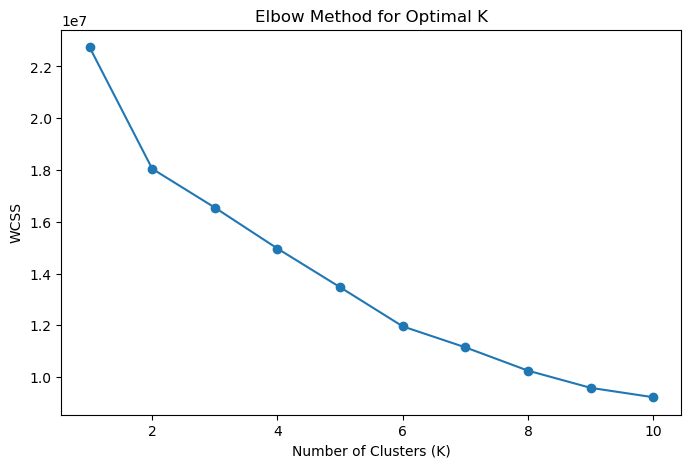

In [3]:
# Determine the number of clusters using Elbow Method

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  # Within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)  # Append the WCSS for each K

# Plot the Elbow graph to find the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()


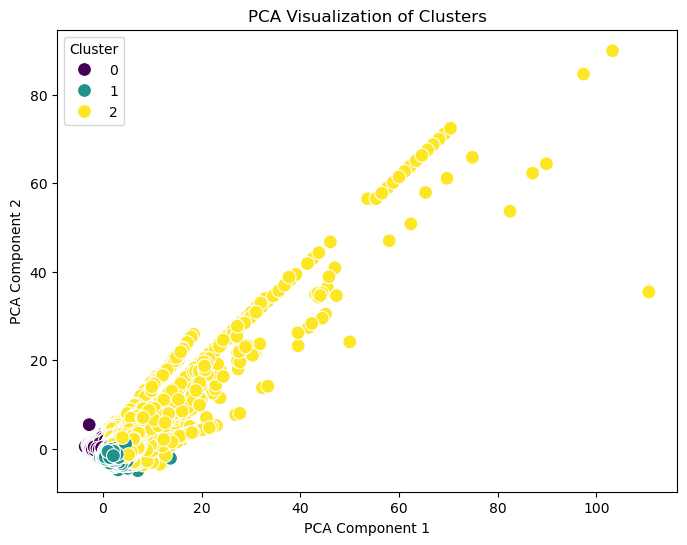

In [4]:
# Step 3: Apply K-means clustering with the chosen K
optimal_k = 3  # Set this based on the Elbow Method result
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Assign cluster labels using .loc[] to avoid the warning
df_cleaned = df_cleaned.copy()  # Create a copy to avoid SettingWithCopyWarning
df_cleaned.loc[:, 'cluster'] = kmeans.fit_predict(scaled_data)

# PCA for Data Visualization with clusters
from sklearn.decomposition import PCA
import seaborn as sns

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a scatter plot of the PCA result with clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_cleaned['cluster'], palette='viridis', s=100)
plt.title('PCA Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()


In [ ]:
# Evaluate the clustering with Silhouette Score
from sklearn.metrics import silhouette_score

# Print a quick check on the 'cluster' column to ensure it's there
print(df_cleaned['cluster'].head())  # Make sure clusters are assigned

# Compute the Silhouette Score
try:
    silhouette_avg = silhouette_score(scaled_data, df_cleaned['cluster'])
    print(f'Silhouette Score: {silhouette_avg}')
except Exception as e:
    print(f"Error calculating Silhouette Score: {e}")


0    0
1    0
2    0
3    0
4    0
Name: cluster, dtype: int32
